<a href="https://colab.research.google.com/github/majorquev/Introduccion_a_ciencia_de_datos_R_v2/blob/main/Clases/Clase7/Clase7_2_clasificaci%C3%B3n_parte1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parte 7: Modelos de clasificación en R


**Autor:** Miguel Jorquera Viguera<br>
**E-mail:** majorquev@gmail.com<br>
**Ayudante:** Rodrigo Morales Méndez<br>
**E-mail ayudante:** rumorale1@gmail.com

## Árboles de decisión

Para la implementación de árboles de decisión (CART - classification and regression trees), utilizaremos el package `rpart` y el packages `visNetwork` (en Rstudio) para su visulaización. Otro package para visualizar árboles `rpart.plot`

## Titanic
Para introducir el trabajo con árboles de clasificación, abordaremos el dataset de titanic, el cual contiene información de los pasajeros (título de la persona, nombre, edad, si viaja con hijos, si es casado o no, género, entre otros). El objetivo será predecir si una persona sobrevivirá o no al hundimiento del barco considerando los atributos anterioremente mencionados.

Para más info puede considerar el siguiente notebook, en el cual está basado este ejemplo. https://www.kaggle.com/mrisdal/exploring-survival-on-the-titanic

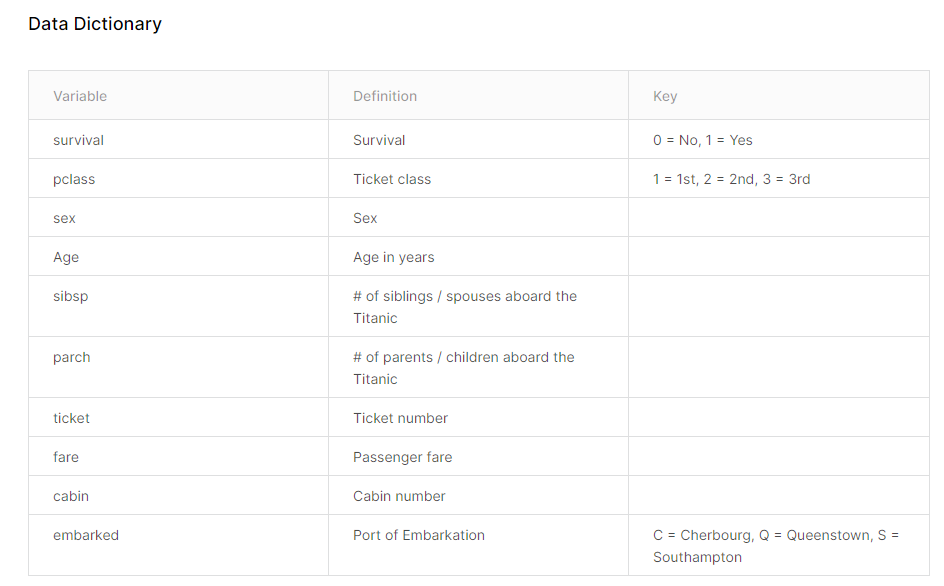


## Exploración


In [ ]:
#install.packages("mice")
#install.packages("randomForest")
#install.packages("VIM") # Ojo que es lenta la instalación


In [ ]:
library(tidyverse)
library(ggplot2)
library(mice) # para trabajar con NA's
library(randomForest) # para random Forest (también lo requiere el package mice)
library(VIM) # para visualizar NA's (tambien se puede con mice pero recomiendo este)



data2 <- read.csv("https://raw.githubusercontent.com/majorquev/Introduccion_a_ciencia_de_datos_R/master/Clases/Clase7/titanic.csv")
head(data2)


In [ ]:

data2 <- data2 %>% 
  separate(Name, c("apellido_titulo", "nombre"),sep = "[\\.]") %>% 
  separate(apellido_titulo, c("apellido","titulo"),sep = "[\\,]") %>%
  mutate(titulo = trimws(titulo)) 

data2 %>%
  count(titulo) %>% 
  arrange(desc(n))







In [ ]:
# Títulos con poca frecuencia se colapsan en la categoría raro
raro <- c(
"Dr"               
,"Rev"              
,"Col"              
,"Major"            
,"Mlle"             
,"Capt"             
,"Don"              
,"Jonkheer"         
,"Lady"             
,"Mme"              
,"Ms"               
,"Sir"              
,"the Countess"
,"Dona")    

data2 <- data2 %>%
  mutate(titulo = case_when(  titulo == "Mlle" ~"Miss"
                            , titulo == "Ms"   ~"Miss"
                            , titulo == "Mme"  ~"Mrs"
                            , titulo %in% raro ~ "raro"
                            , TRUE ~ titulo
                            )
         )

count(data2, titulo) %>%
  arrange(desc(n))
  

In [ ]:
# Se crea variable que indica el "tamaño" de la familia
data2 <- data2 %>% 
  mutate(n_familia = SibSp + Parch + 1)



In [ ]:
# Genere un gráfico de barras que muestre la cantidad de personas que se salvaron,
# en función del tamaño de la familia

ggplot(data2, aes(x = n_familia, fill = factor(Survived))) +
  geom_bar(position='dodge') + 
  scale_x_continuous(breaks=c(1:11)) +
  labs(x = 'Tamaño Familia')

In [ ]:
# categorizacion n_familia ------------------------------------------------

# cree una variable con tres categorias a partir de la variable n_familia
data2 <- data2 %>% 
  mutate(tipo_familia = case_when(
                              n_familia == 1 ~ "solo",
                              n_familia %in% c(2,3,4) ~ "pequena",
                              n_familia > 4 ~ "grande",
                              TRUE~ "otro"
                              )
    )


In [ ]:
#Podemos visualizar los datos faltantes con VIM
VIM::aggr(data2)


In [ ]:
# Estas son variables categóricas -----------------------------------------
factores <- c('Pclass','Sex','Embarked',
                 'titulo','tipo_familia')

# modificarlas
 data2 <- data2 %>% 
   mutate(across(all_of(factores), ~ as.factor(.)))



In [ ]:

set.seed(112) 
# Imputación NA's Edad ----------------------------------------------------

mice_mod <- mice(data2[, !names(data2) %in% c('PassengerId','Name','Ticket','Cabin','Survived')]
                 , method = 'rf') 

mice_output <- complete(mice_mod) # con complete podemos recuperar el dataset original pero con los casos imputados

data2$Age <- mice_output$Age 



In [ ]:
# Variables niño y madre --------------------------------------------------

data2 <- data2 %>% 
  mutate( menor = ifelse(Age < 18,"menor","adulto"),
          madre = ifelse(  Sex == "female" 
                         & Parch > 0 
                         & Age > 18 
                         & titulo != "Miss", 
                         "madre",
                         "no_madre"
                         )
           )

summary(data2$Embarked)


In [ ]:

data2 %>% 
  write.csv("titanic_v2.csv",row.names = F)